ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10, 2) + inhomogeneous part.

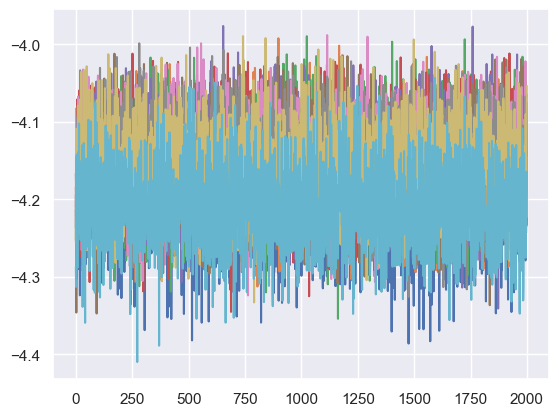

In [1]:
# Import necessary libraries
import os
import gym
from environments.energy_management_env import EnergyManagementEnv

# Import the Agent class from your code


# Import environment registration function
from environments.env_registration import register_env

# Define environment parameters
env_params = {
    'SOC_min': 0.2,
    'SOC_max': 0.8,
    'E': 1000,
    'lambda_val': 0.1,
    'data_path': 'data/Data_input.csv',
    'initial_SOC': 0.5  # Set to None if not using an initial_SOC
}

# Register the custom environment
register_env('EnergyManagement-v0', 'environments.env_registration:environment_creator',{'environment_class': EnergyManagementEnv, **env_params})


import numpy as np
import gym
import seaborn as sns
import matplotlib.pyplot as plt

from rl_monitoring_utils.vectorized_env_wrapper import VectorizedEnvWrapper
from policies.categorical_policy import CategoricalPolicy
from learning_utils.value_estimator import ValueEstimator
from agents.a2c import A2C
from agents.ppo import PPO
from agents.reinforce import REINFORCE

# Assuming the implementations of A2C, PPO, REINFORCE accept an argument to return total rewards per epoch

def run_experiment(agent_function, energy_management, num_runs=10, **kwargs):
    all_totals = []
    for _ in range(num_runs):
        categorical = CategoricalPolicy(energy_management, lr=1e-2)
        if agent_function in [PPO, A2C]:
            value_estimator = ValueEstimator(energy_management, lr=1e-2)
            totals = agent_function(energy_management, categorical, value_estimator, **kwargs)
        else: # REINFORCE
            totals = agent_function(energy_management, CategoricalPolicy(energy_management, lr=1e-4), **kwargs)
        all_totals.append(totals)
    return np.array(all_totals)

def plot_results(results, labels):
    plt.figure(figsize=(10, 6))  # Increase figure size for better readability
    for label, data in zip(labels, results):
        means = np.mean(data, axis=0)
        stds = np.std(data, axis=0)
        epochs = range(data.shape[1])  # Corrected to data.shape[1] for dynamic length
        plt.fill_between(epochs, means - stds, means + stds, alpha=0.1)
        plt.plot(epochs, means, label=label)
    
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.title('RL Agent Performance with Standard Deviation')
    plt.grid(True)  # Add grid for better readability
    plt.show()

num_runs = 10  # Number of runs for averaging
num_envs = 8  # Number of environments for vectorization

energy_management = VectorizedEnvWrapper(gym.make("EnergyManagement-v0"), num_envs=num_envs)

results = []
results.append(run_experiment(PPO, energy_management, epochs=2000, gamma=1, T=720, kl_threshold=1e-2, num_runs=num_runs))
results.append(run_experiment(A2C, energy_management, epochs=2000, gamma=1, T=720, num_runs=num_runs))
results.append(run_experiment(REINFORCE, energy_management, epochs=2000, gamma=1, T=720, num_runs=num_runs))

plot_results(results, ['PPO', 'A2C', 'REINFORCE'])
# plot_results(results, ['PPO'])
